In [16]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Lambda, Conv2D, MaxPooling2D
import os
import random
from  keras.regularizers import l2
from sklearn.preprocessing import PowerTransformer


In [17]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed(42)
train = pd.read_csv('Embeddings/Prot_t5/train_t5_pssm.csv')
val = pd.read_csv('Embeddings/Prot_t5/val_t5_pssm.csv')
test = pd.read_csv('Embeddings/Prot_t5/test_t5_pssm.csv')

# train = pd.concat([train, val])

print(train.shape)
print(val.shape)
print(test.shape)

# Make validation set imbalanced
val_pos = val[val['label'] == 1]
val_neg = val[val['label'] == 0]

# val_pos = val_pos.sample(frac=0.1, random_state=4)

val = pd.concat([val_pos, val_neg])

# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

X_train_PSSM = train['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_val_PSSM = val['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))

X_train_PSSM = np.stack(X_train_PSSM.values)
X_val_PSSM = np.stack(X_val_PSSM.values)
X_test_PSSM = np.stack(X_test_PSSM.values)

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# use power transform to normalize the pssm
scaler = PowerTransformer()
X_train_PSSM = scaler.fit_transform(X_train_PSSM)
X_val_PSSM = scaler.transform(X_val_PSSM)
X_test_PSSM = scaler.transform(X_test_PSSM)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

#print shapes
print(X_train_embeddings.shape)
print(X_val_embeddings.shape)
print(X_test_embeddings.shape)
print(X_train_PSSM.shape)
print(X_val_PSSM.shape)
print(X_test_PSSM.shape)
print(X_train_num.shape)
print(X_val_num.shape)
print(X_test_num.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)



(8411, 6)
(935, 6)
(3226, 6)
(8411, 1024)
(935, 1024)
(3226, 1024)
(8411, 20)
(935, 20)
(3226, 20)
(8411, 33)
(935, 33)
(3226, 33)
(8411,)
(935,)
(3226,)


In [18]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, X_val_PSSM = None, y_val = None, print_metrics=True):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    elif X_val_PSSM is None:
        y_pred_probs = model.predict([X_val, X_val_pt5])
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    if print_metrics:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'MCC: {mcc:.4f}')
        print(f'AUC: {auc:.4f}')
        print(f'AUPRC: {auprc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return accuracy, mcc, auc, auprc, precision, recall, specificity, f1

In [19]:
from keras.models import Model
from keras.layers import Input, Embedding, SimpleRNN, Dense, Dropout, Flatten

def create_rnn_model():
    # RNN branch for sequence data
    input_shape_rnn = (33,)  # Example shape, adjust according to your input
    rnn_input = Input(shape=input_shape_rnn)
    x_rnn = Embedding(input_dim=64, output_dim=21)(rnn_input)  # Embedding layer
    x_rnn = SimpleRNN(32, activation='relu')(x_rnn)  # RNN layer

    # Dense layer for sequence features
    x_rnn = Dense(32, activation='relu')(x_rnn)  # Dense layer
    x_rnn = Dropout(0.3)(x_rnn)  # Dropout for regularization

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(x_rnn)  # Output layer

    # Create the model
    rnn_model = Model(inputs=rnn_input, outputs=output_layer)
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return rnn_model

In [20]:
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout

def create_bilstm_model():
    # BiLSTM branch for sequence data
    input_shape_bilstm = (33,)  # Example shape, adjust according to your input
    bilstm_input = Input(shape=input_shape_bilstm)
    x_bilstm = Embedding(input_dim=64, output_dim=21)(bilstm_input)  # Embedding layer
    x_bilstm = LSTM(32, return_sequences=False)(x_bilstm)  # BiLSTM layer

    # Dense layer for sequence features
    x_bilstm = Dense(64, activation='relu')(x_bilstm)  # Dense layer
    x_bilstm = Dropout(0.3)(x_bilstm)  # Dropout for regularization

    # Output layer
    x_bilstm = Dense(1, activation='sigmoid')(x_bilstm)  # Output layer

    # Create the model
    bilstm_model = Model(inputs=bilstm_input, outputs=x_bilstm)
    bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return bilstm_model

In [21]:
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Dropout, Flatten

def create_fnn_model():
    # FNN branch for sequence data
    input_shape_fnn = (33,)  # Example shape, adjust according to your input
    fnn_input = Input(shape=input_shape_fnn)
    x_fnn = Embedding(input_dim=64, output_dim=21)(fnn_input)  # Embedding layer

    # Flatten the embedded input to feed into dense layers
    x_fnn = Flatten()(x_fnn)  # Flatten the output of the embedding layer

    # Dense layers for sequence features
    x_fnn = Dense(64, activation='relu')(x_fnn)  # First Dense layer
    x_fnn = Dropout(0.3)(x_fnn)  # Dropout for regularization
    x_fnn = Dense(32, activation='relu')(x_fnn)  # Second Dense layer
    x_fnn = Dropout(0.3)(x_fnn)  # Dropout for regularization
    x_fnn = Dense(1, activation='sigmoid')(x_fnn)  # Output layer for binary classification

    # Create the model
    fnn_model = Model(inputs=fnn_input, outputs=x_fnn)
    fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return fnn_model

In [22]:
def create_conv1D_model():
    # Conv1D branch for sequence data
    input_shape_conv1d = (33,)  # Example shape, adjust according to your input
    conv1d_input = Input(shape=input_shape_conv1d)
    x_conv1d = Embedding(input_dim=64, output_dim=21)(conv1d_input)  # Embedding layer
    x_conv1d = Conv1D(64, 5, activation='relu')(x_conv1d)  # Conv1D layer
    x_conv1d = MaxPooling1D(2)(x_conv1d)  # MaxPooling layer

    x_conv1d = Conv1D(32, 3, activation='relu')(x_conv1d)  # Conv1D layer
    x_conv1d = MaxPooling1D(2)(x_conv1d)  # MaxPooling layer
    x_conv1d = Flatten()(x_conv1d)  # Flatten the output of the Conv1D layer

    # Dense layers for sequence features
    x_conv1d = Dense(32, activation='relu')(x_conv1d)  # Dense layer
    x_conv1d = Dropout(0.3)(x_conv1d)  # Dropout for regularization

    # Output layer
    x_conv1d = Dense(1, activation='sigmoid')(x_conv1d)  # Output layer

    # Create the model
    conv1d_model = Model(inputs=conv1d_input, outputs=x_conv1d)
    conv1d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return conv1d_model

In [23]:
def create_conv2D_model():
    conv_input = Input(shape=(33,), name='conv_input')

    # Embedding layer
    x = Embedding(input_dim=64, output_dim=21)(conv_input)

    x = Lambda(lambda x: tf.expand_dims(x, 3))(x)

    # Convolutional layers
    x = Conv2D(16, kernel_size=(29, 3), activation='relu',
               kernel_initializer='he_normal', padding='VALID')(x)
    x = Flatten()(x)

    x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.3)(x)

    # Output layer
    x = Dense(1, activation='sigmoid')(x)
    
    conv2D_model = Model(inputs=conv_input, outputs=x)
    conv2D_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return conv2D_model

In [24]:
def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_tensor)


    # Branch 6: MaxPooling + Conv1D with kernel size 1
    branch7 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
    branch7 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch7)


    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch7])
    return output

def create_inception_model():
    # Conv1D branch for sequence data
    input_shape_conv = (33,)  # Example shape, adjust according to your input
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21)(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    output_conv = Dense(1, activation='sigmoid')(x_conv)

    # Create the model
    conv_model = Model(inputs=conv_input, outputs=output_conv)
    conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return conv_model


In [10]:
def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def create_res_model():
    # Conv1D branch for sequence data
    input_shape_conv = (33,)  # Example shape, adjust according to your input
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=21, output_dim=21)(conv_input)

    # Apply Residual blocks
    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    output_conv = Dense(1, activation='sigmoid')(x_conv)

    # Create the model
    res_model = Model(inputs=conv_input, outputs=output_conv)
    res_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return res_model

In [25]:
rnn_model = create_rnn_model()
bilstm_model = create_bilstm_model()
fnn_model = create_fnn_model()
conv1d_model = create_conv1D_model()
conv2D_model = create_conv2D_model()
inception_model = create_inception_model()
res_model = create_res_model()

epochs = 100
batch_size = 128
patience = 10

set_seed(4)
# Train the models
rnn_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
bilstm_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
fnn_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
conv1d_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
conv2D_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
inception_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
res_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])

--- RNN ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.6920
MCC: 0.3804
AUC: 0.6882
AUPRC: 0.6886
Precision: 0.6907
Recall: 0.7551
Specificity: 0.6213
F1 Score: 0.7215
--- BiLSTM ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.7112
MCC: 0.4194
AUC: 0.7075
AUPRC: 0.7609
Precision: 0.7074
Recall: 0.7733
Specificity: 0.6417
F1 Score: 0.7389
--- FNN ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7123
MCC: 0.4223
AUC: 0.7109
AUPRC: 0.7961
Precision: 0.7246
Recall: 0.7348
Specificity: 0.6871
F1 Score: 0.7296
--- Conv1D ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7551
MCC: 0.5088
AUC: 0.7545
AUPRC: 0.8225
Precision: 0.7699
Recall: 0.7652
Specificity: 0.7438
F1 Score: 0.7675
--- Conv2D ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7369
MCC: 0.4712
AUC: 0.7347
AUPRC: 0.8239
Precision: 0.7403
Recall: 0.7733
Specificity: 0.6961
F1 Score: 0.7564
--- Inception ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7668
MCC: 0.5316
AUC: 0.7644
AUPRC: 0.8248

<Axes: title={'center': 'Model Performance on an Imbalanced Validation Set'}, ylabel='Score'>

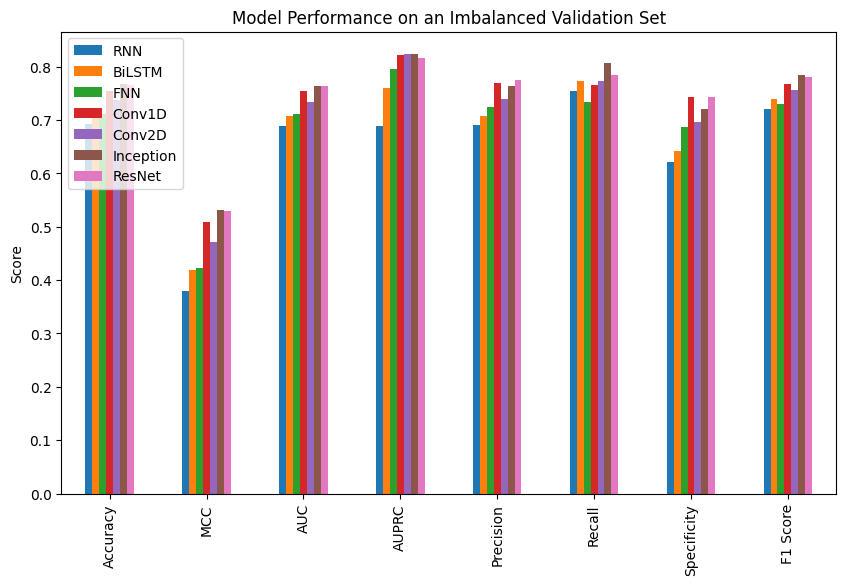

In [26]:

# Create dictionary to store the results
results = {}

model_names = ['RNN', 'BiLSTM', 'FNN', 'Conv1D', 'Conv2D', 'Inception', 'ResNet']
models = [rnn_model, bilstm_model, fnn_model, conv1d_model, conv2D_model, inception_model, res_model]

# Evaluate the models
for model_name, model in zip(model_names, models):
    print(f'--- {model_name} ---')
    results[model_name] = evaluate_model(model, X_val=X_val_num, y_val=y_val)

# Plot the results for comparison
metrics = ['Accuracy', 'MCC', 'AUC', 'AUPRC', 'Precision', 'Recall', 'Specificity', 'F1 Score']
results_df = pd.DataFrame(results, index=metrics)

results_df.plot(kind='bar', figsize=(10, 6), ylabel='Score', title='Model Performance on an Imbalanced Validation Set')
#save the plot
# plt.savefig('word_embedding_models.pdf', format='pdf', bbox_inches='tight')

Iteration 1
Evaluating RNN
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.6468
MCC: 0.2792
AUC: 0.7110
AUPRC: 0.1991
Precision: 0.2281
Recall: 0.7959
Specificity: 0.6261
F1 Score: 0.3545
Evaluating BiLSTM
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.6468
MCC: 0.2680
AUC: 0.7022
AUPRC: 0.3044
Precision: 0.2249
Recall: 0.7755
Specificity: 0.6289
F1 Score: 0.3486
Evaluating FNN
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.6866
MCC: 0.2919
AUC: 0.7161
AUPRC: 0.3465
Precision: 0.2450
Recall: 0.7551
Specificity: 0.6771
F1 Score: 0.3700
Evaluating Conv1D
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.7289
MCC: 0.3333
AUC: 0.7402
AUPRC: 0.3741
Precision: 0.2761
Recall: 0.7551
Specificity: 0.7252
F1 Score: 0.4044
Evaluating Conv2D
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
Accuracy: 0.7065
MCC: 0.3218
AUC: 0.7362
AUPRC: 0.3967
Precision: 0.2621
Recall: 0.7755
Specificity: 0.6969
F1 Score: 0.3918
Evaluating Inception
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.7289


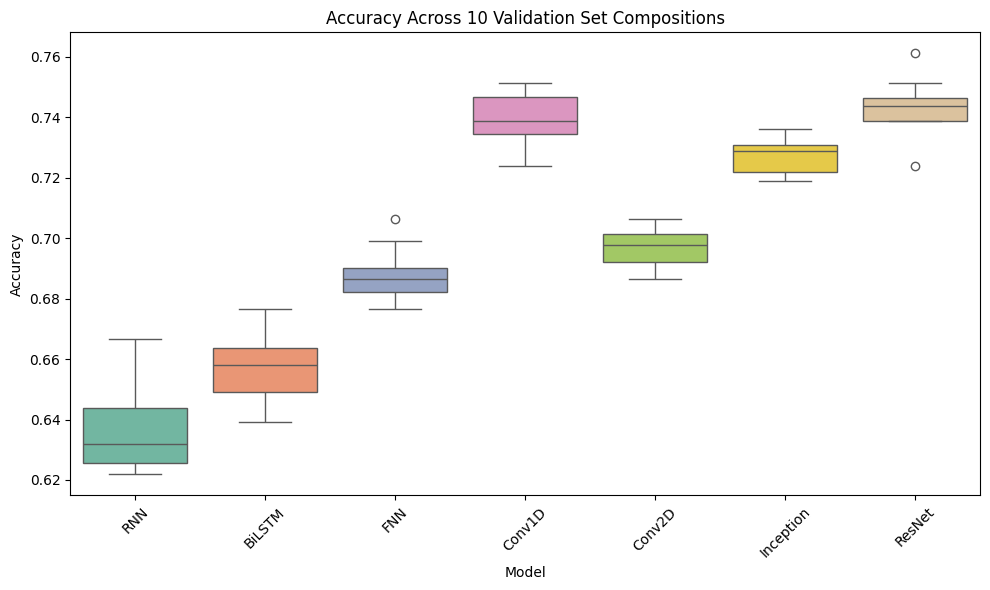

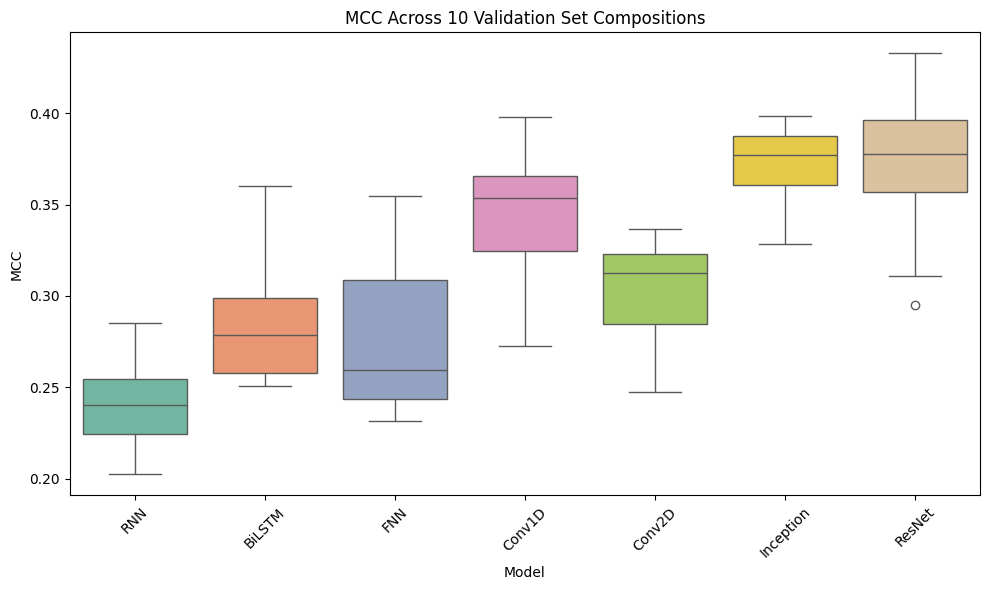

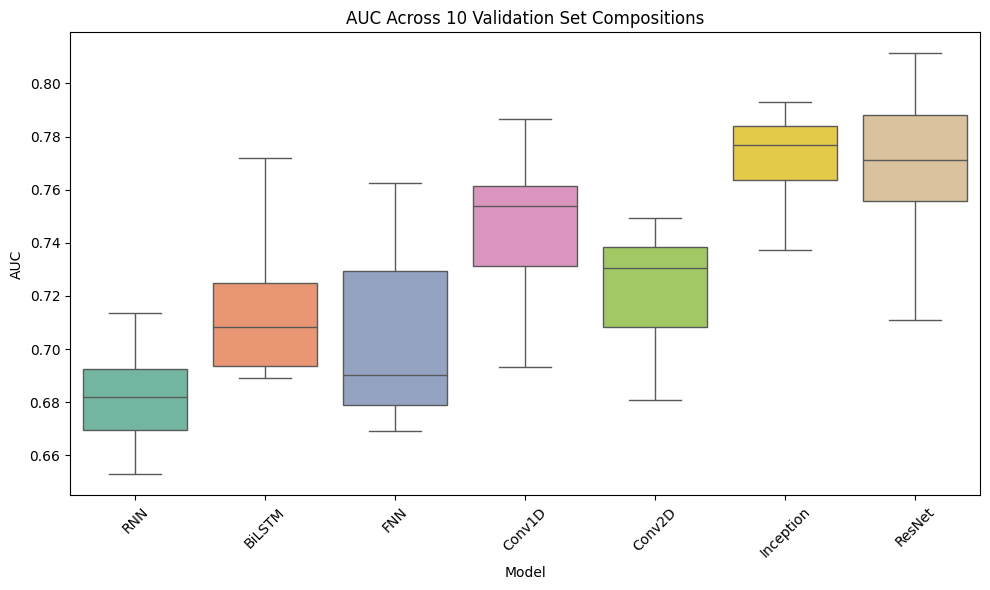

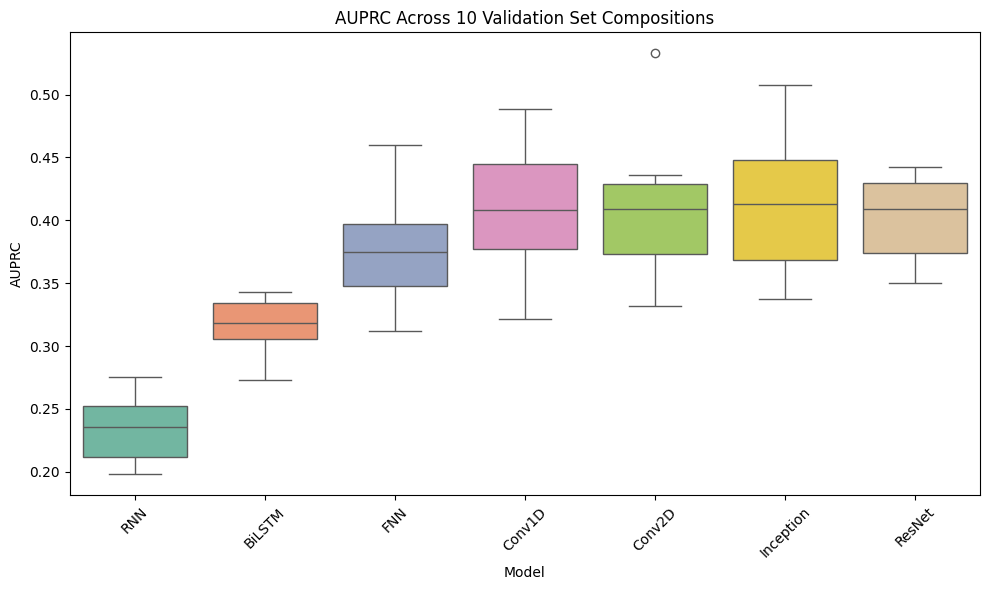

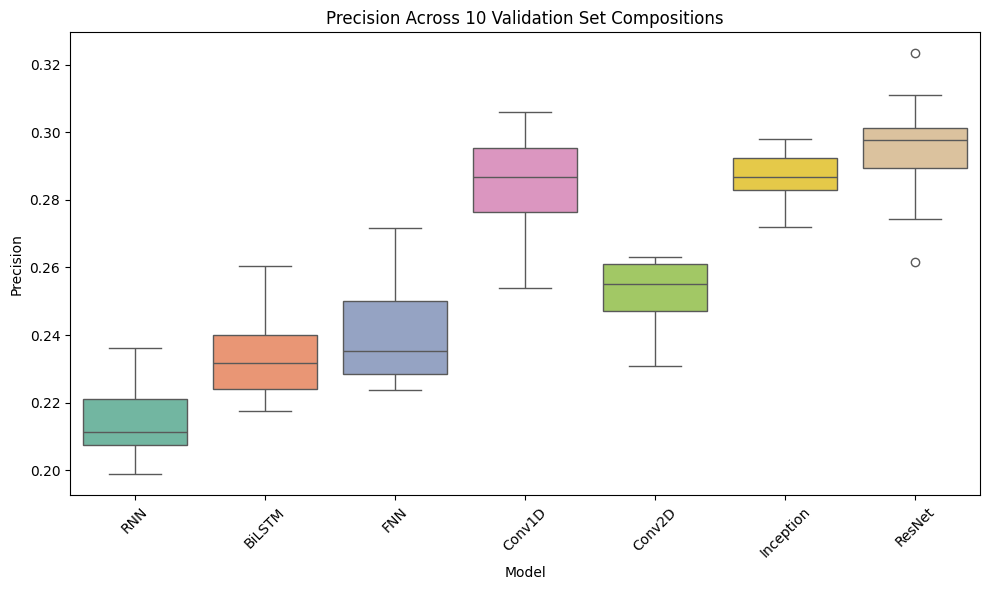

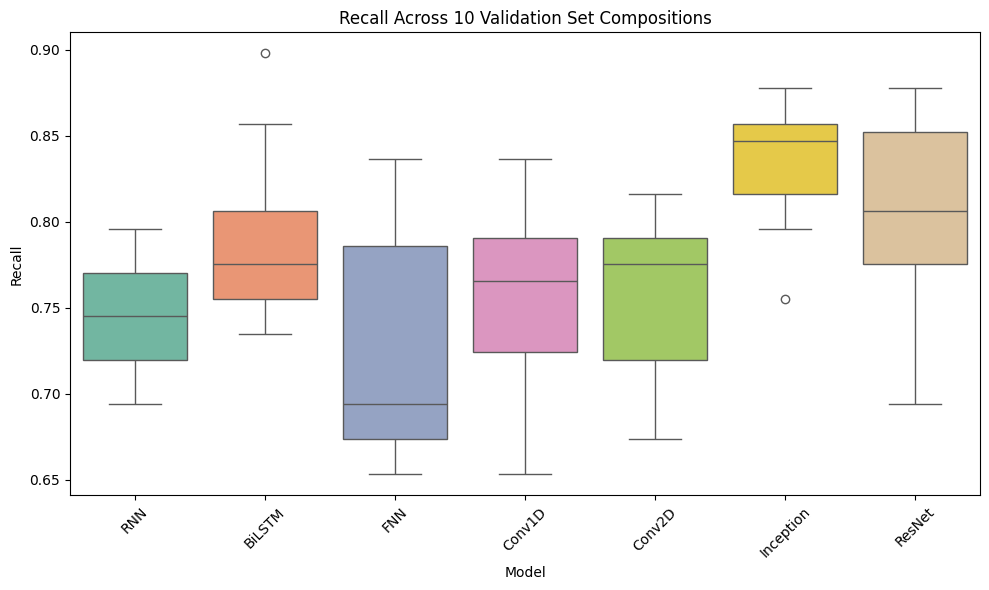

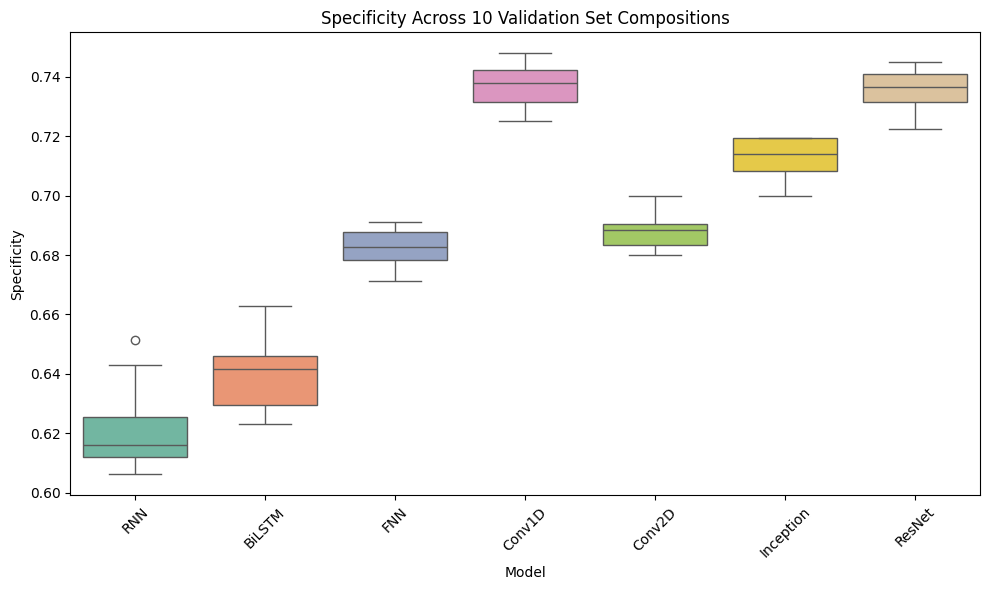

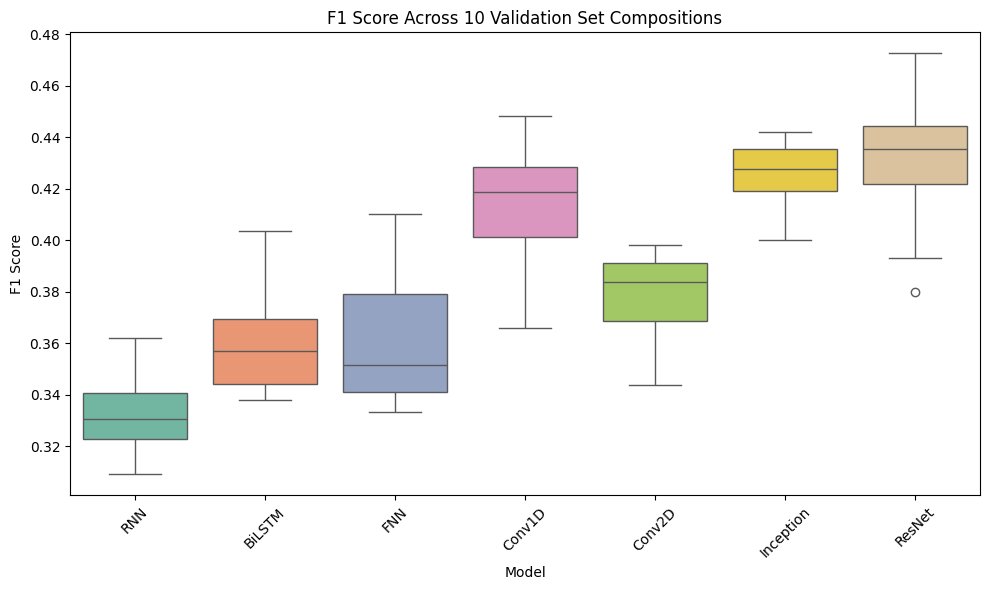

In [27]:
import seaborn as sns

# Initialize an empty dictionary to store the results
results = {metric: {model_name: [] for model_name in model_names} for metric in metrics}

# Perform 10 iterations with different positive validation set compositions
num_iterations = 10
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}")
    
    # Sample 10% of the positive samples randomly
    val_pos_sampled = val_pos.sample(frac=0.1, random_state=iteration)
    val_neg_sampled = val_neg.sample(frac=0.8, random_state=iteration)
    val_sampled = pd.concat([val_pos_sampled, val_neg_sampled])
    
    # Convert the sequences and labels for the new validation set
    X_val_sampled = [[aa_to_int[aa] for aa in seq] for seq in val_sampled['sequence'].values]
    X_val_sampled = np.array(X_val_sampled)
    y_val_sampled = val_sampled['label'].values
    
    # Evaluate each model
    for model_name, model in zip(model_names, models):
        print(f'Evaluating {model_name}')
        
        # Evaluate the model and collect the metrics
        scores = evaluate_model(model, X_val=X_val_sampled, y_val=y_val_sampled)
        for metric, score in zip(metrics, scores):
            results[metric][model_name].append(score)

# Convert results dictionary to a DataFrame for plotting
results_df = {metric: pd.DataFrame(data) for metric, data in results.items()}

# Create box-and-whisker plots for each metric
for metric, df in results_df.items():
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, palette="Set2")
    plt.title(f'{metric} Across 10 Validation Set Compositions')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'Plots/Model Selection/Word_embedding/Word_embedding_{metric}_boxplot.pdf', format='pdf')
    plt.show()


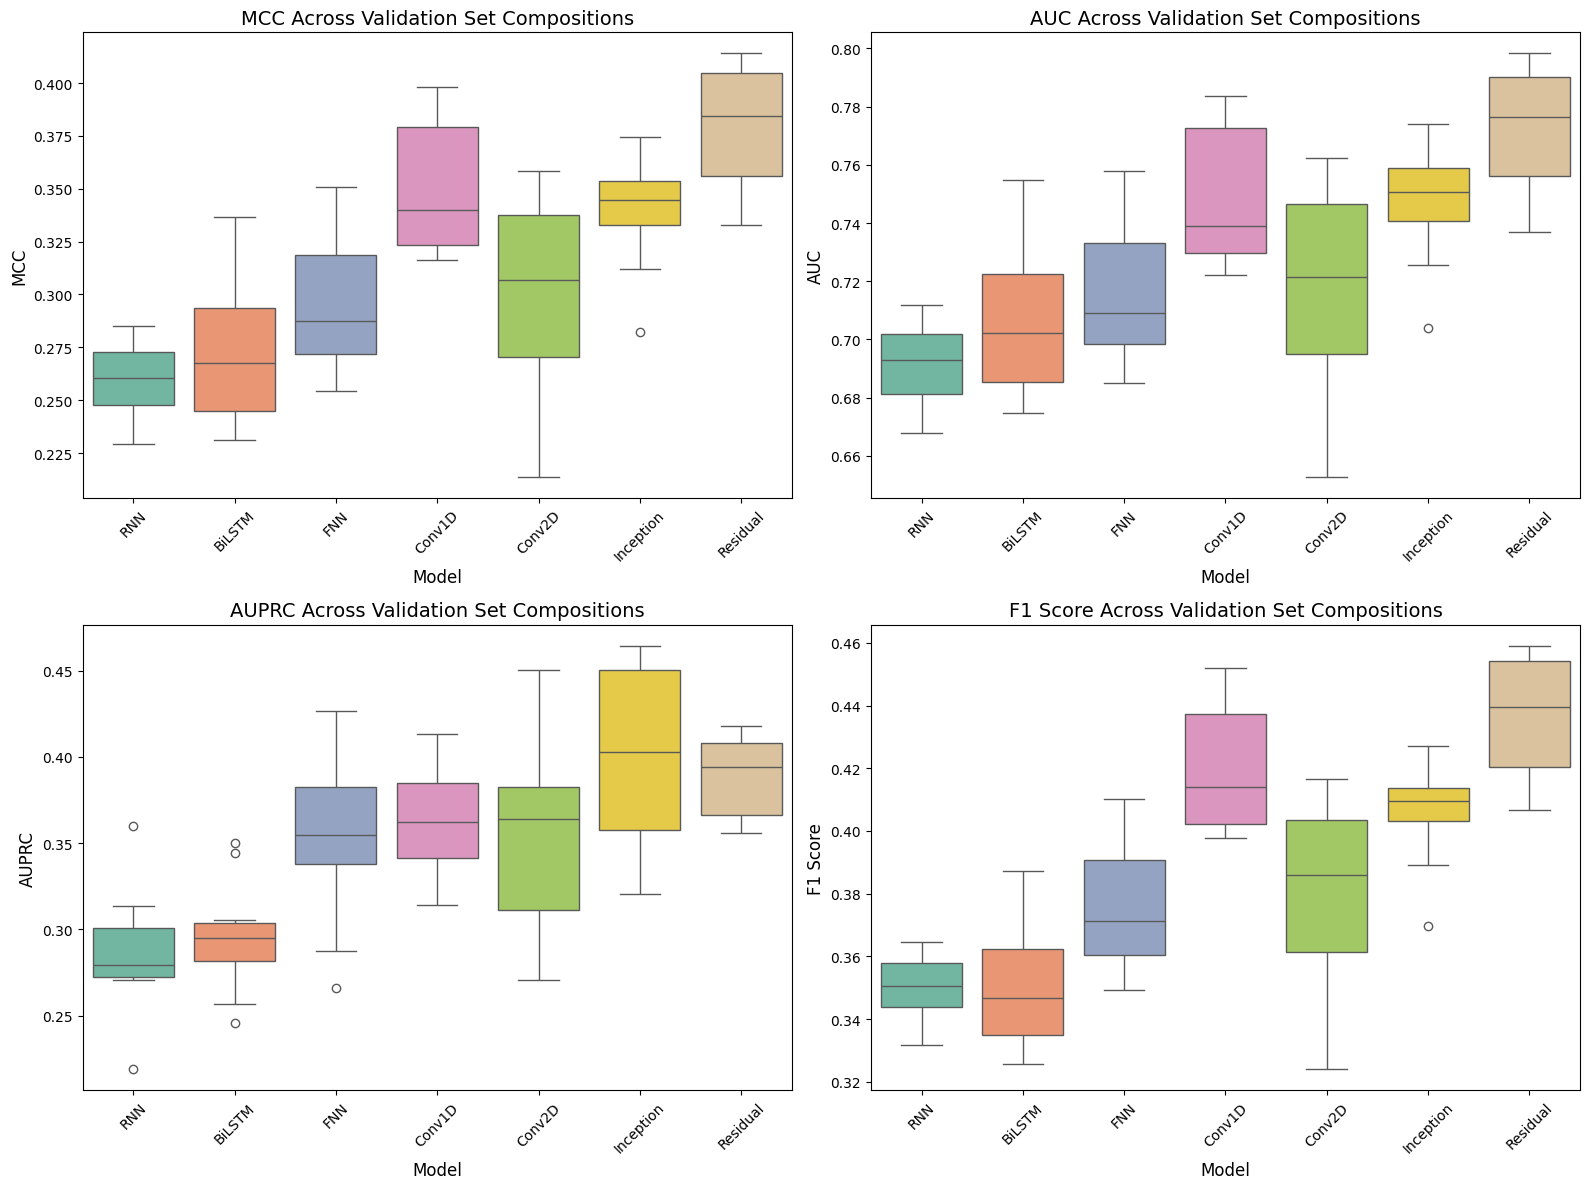

In [22]:
# Select the metrics to display
selected_metrics = ['MCC', 'AUC', 'AUPRC', 'F1 Score']

# Prepare a DataFrame for the selected metrics
results_selected = {metric: pd.DataFrame(data) for metric, data in results.items() if metric in selected_metrics}

# Set up the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten for easy indexing

# Iterate through selected metrics and plot each on a subplot
for i, metric in enumerate(selected_metrics):
    sns.boxplot(
        data=results_selected[metric],
        ax=axes[i],
        palette="Set2"
    )
    axes[i].set_title(f'{metric} Across Validation Set Compositions', fontsize=14)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].set_xlabel('Model', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)

# Adjust layout
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('Plots/Model Selection/Word_embedding/Model_Comparison_Subplots.pdf', format='pdf')

# Display the plot
plt.show()


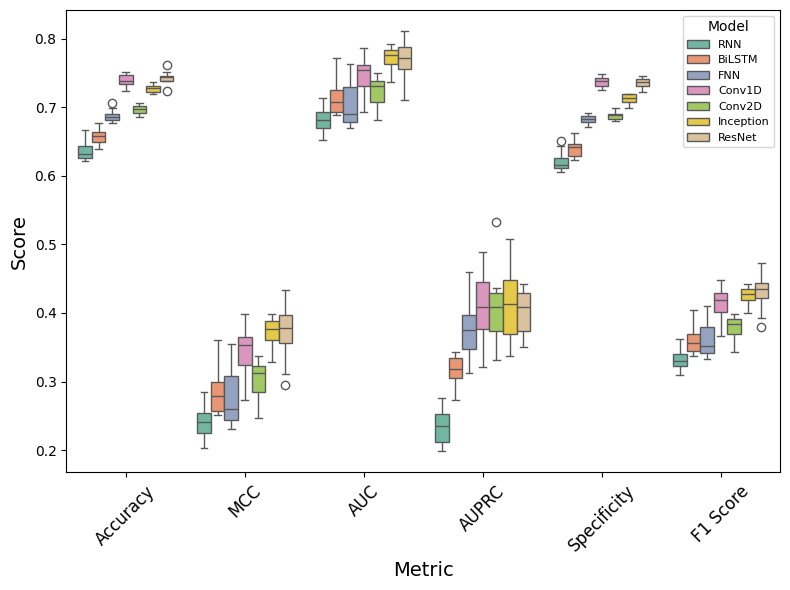

In [28]:
# Select the metrics to display
selected_metrics = ['Accuracy', 'MCC', 'AUC', 'AUPRC', 'Specificity', 'F1 Score']

# Prepare a DataFrame for the selected metrics
results_selected = {metric: pd.DataFrame(data) for metric, data in results.items() if metric in selected_metrics}

# Combine the data for easier plotting
combined_df = pd.concat(
    [df.melt(var_name='Model', value_name='Score').assign(Metric=metric) 
     for metric, df in results_selected.items()],
    ignore_index=True
)

# Create a box-and-whisker plot for the selected metrics
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x='Metric', y='Score', hue='Model', palette="Set2")

# Customize the plot
# plt.title('Model Performance Metrics Across Validation Set Compositions', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Metric', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Model', fontsize=8, loc='upper right')
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('Plots/Model Selection/Word_embedding/Word_embedding_Model_Comparison_new.pdf', format='pdf')

# Display the plot
plt.show()


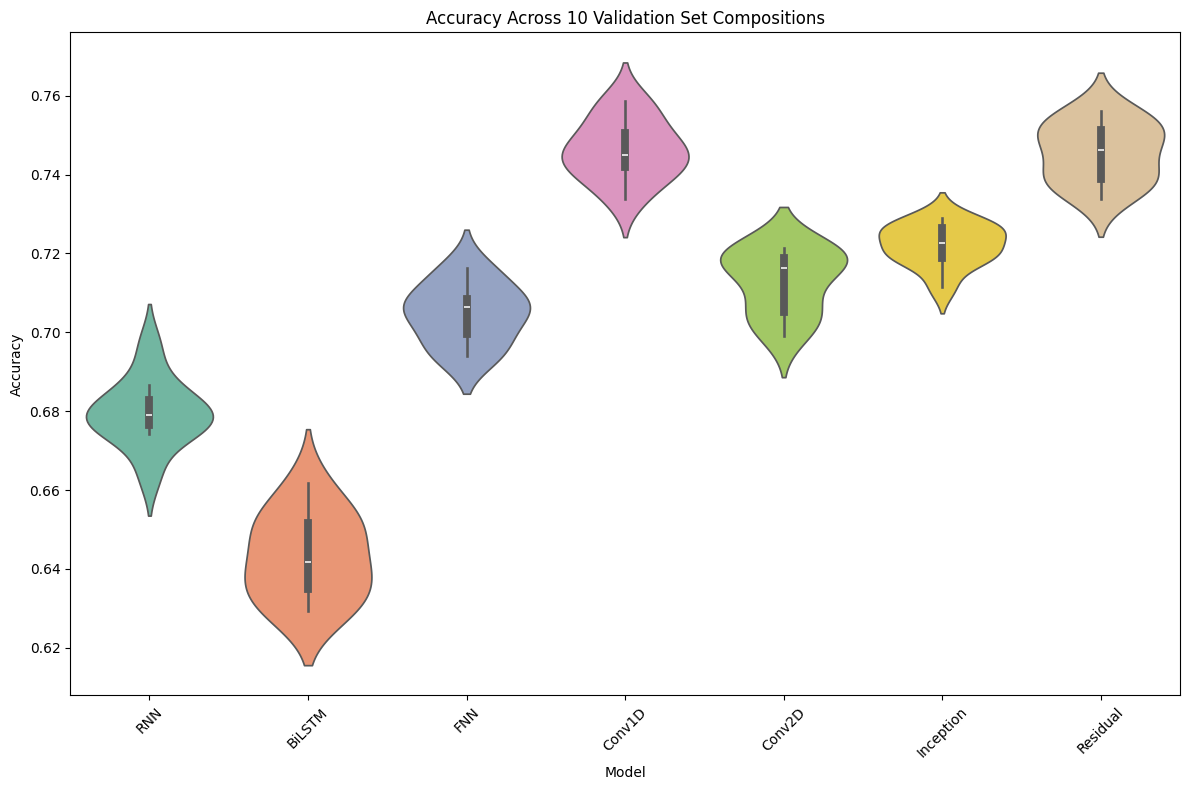

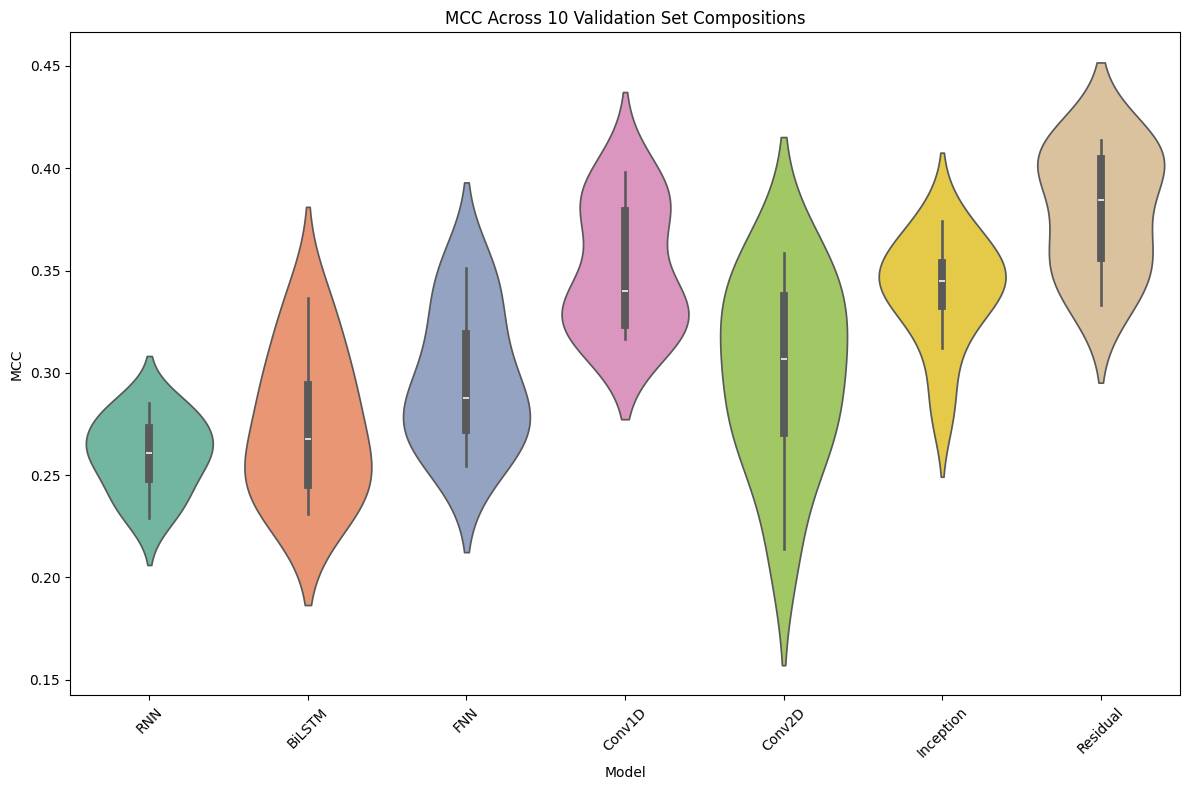

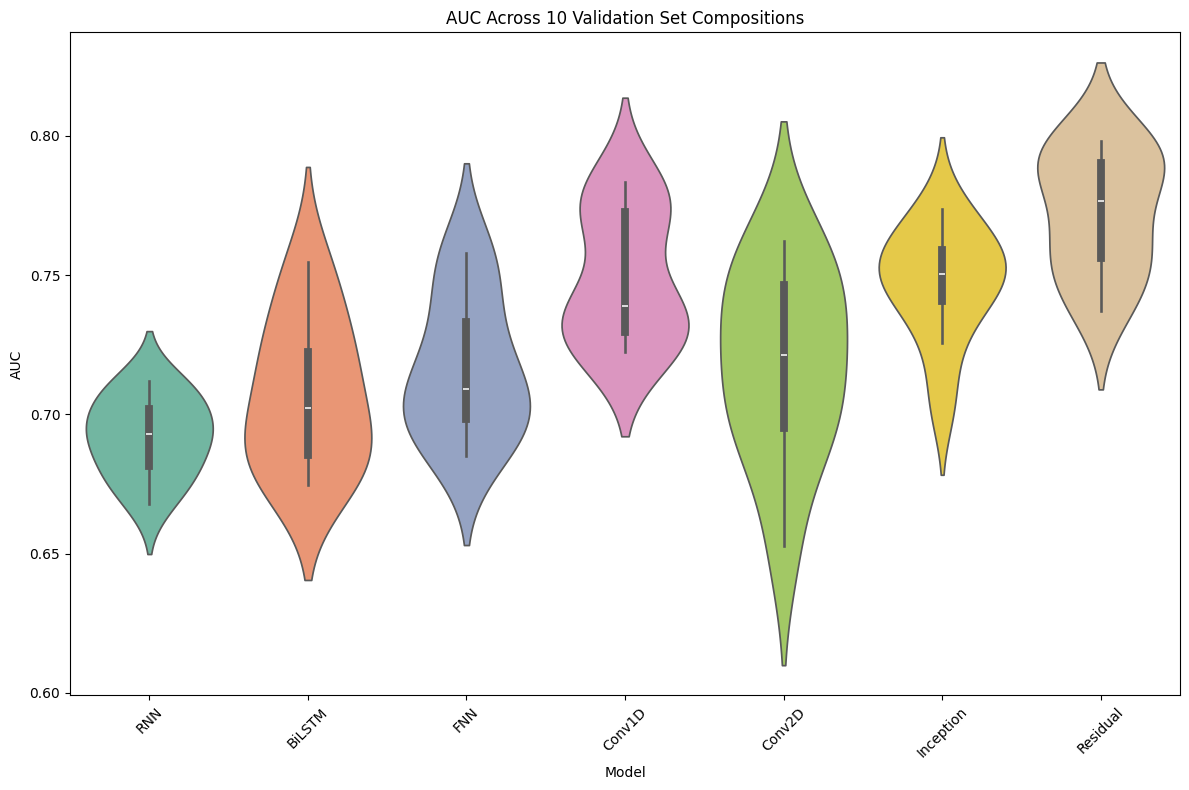

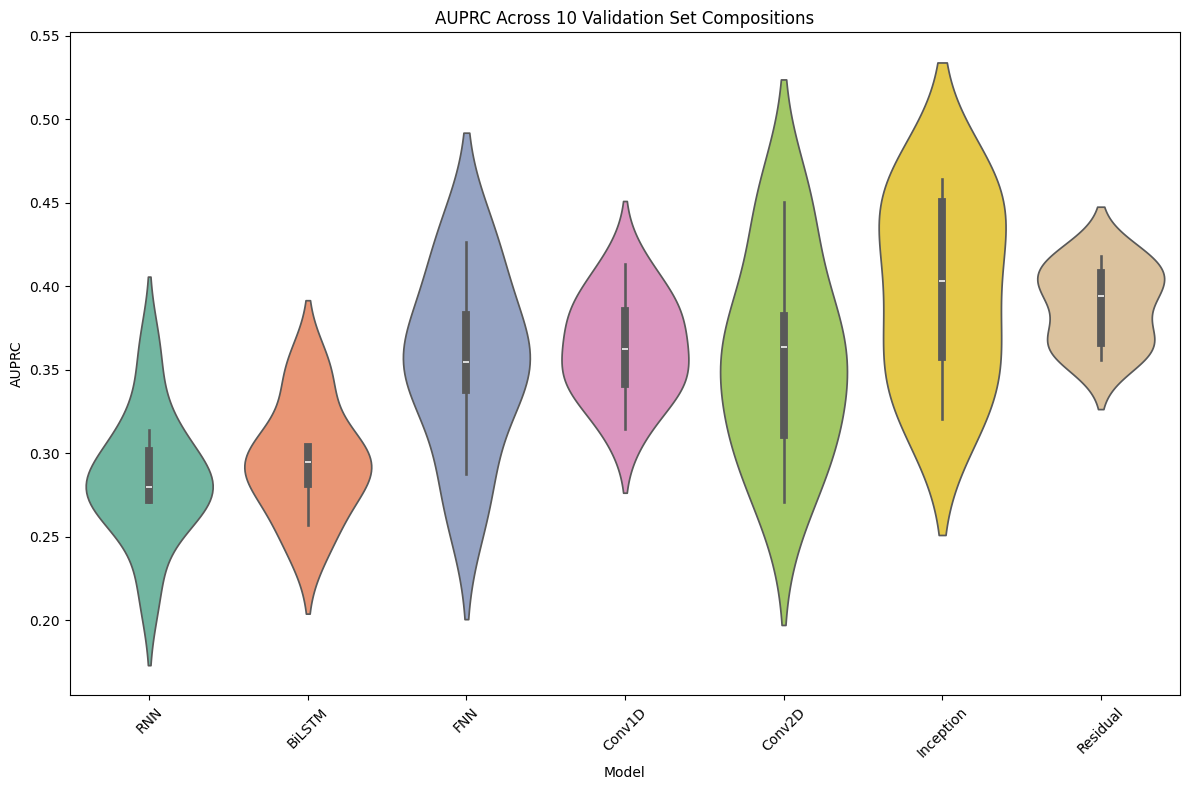

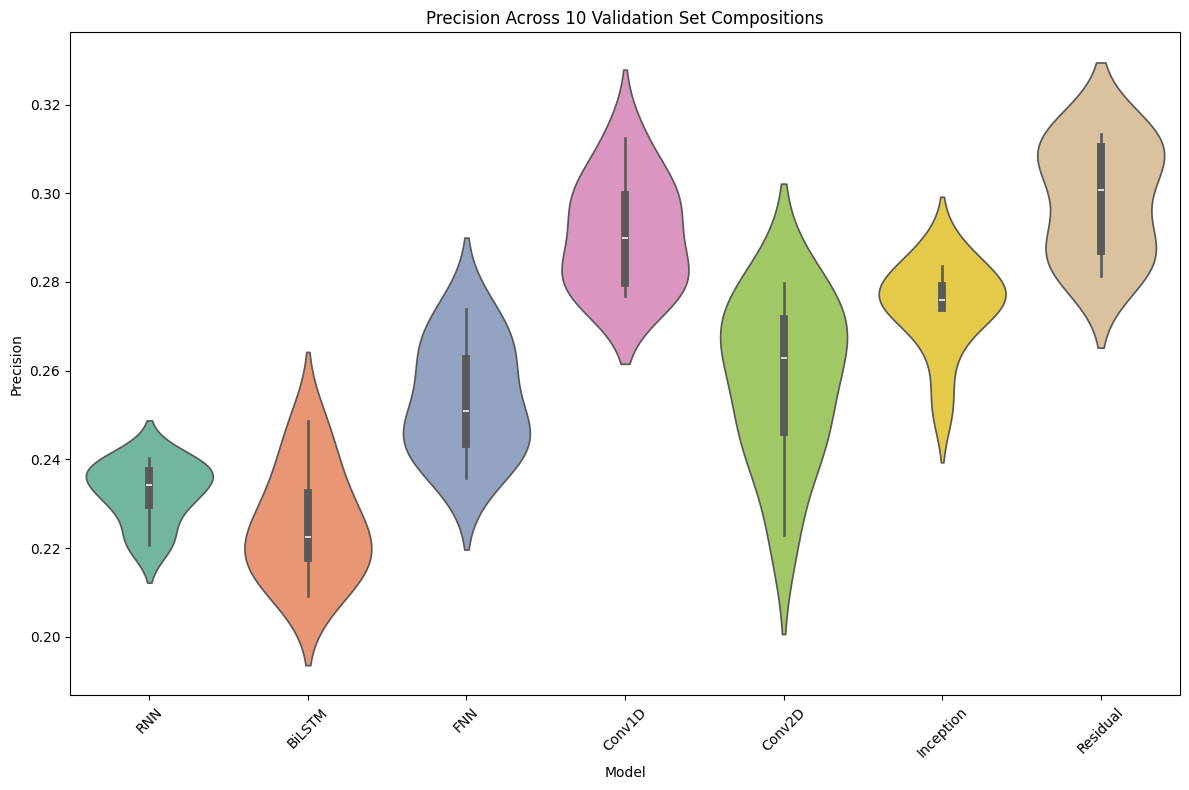

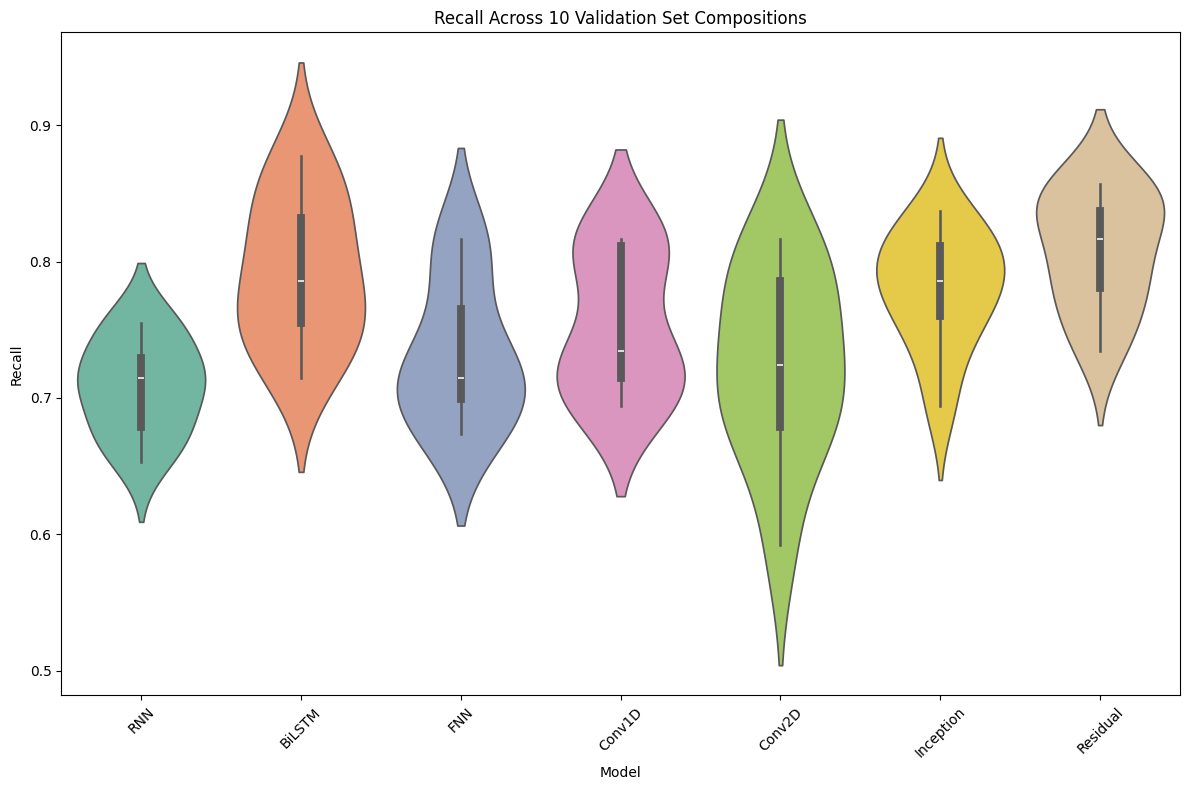

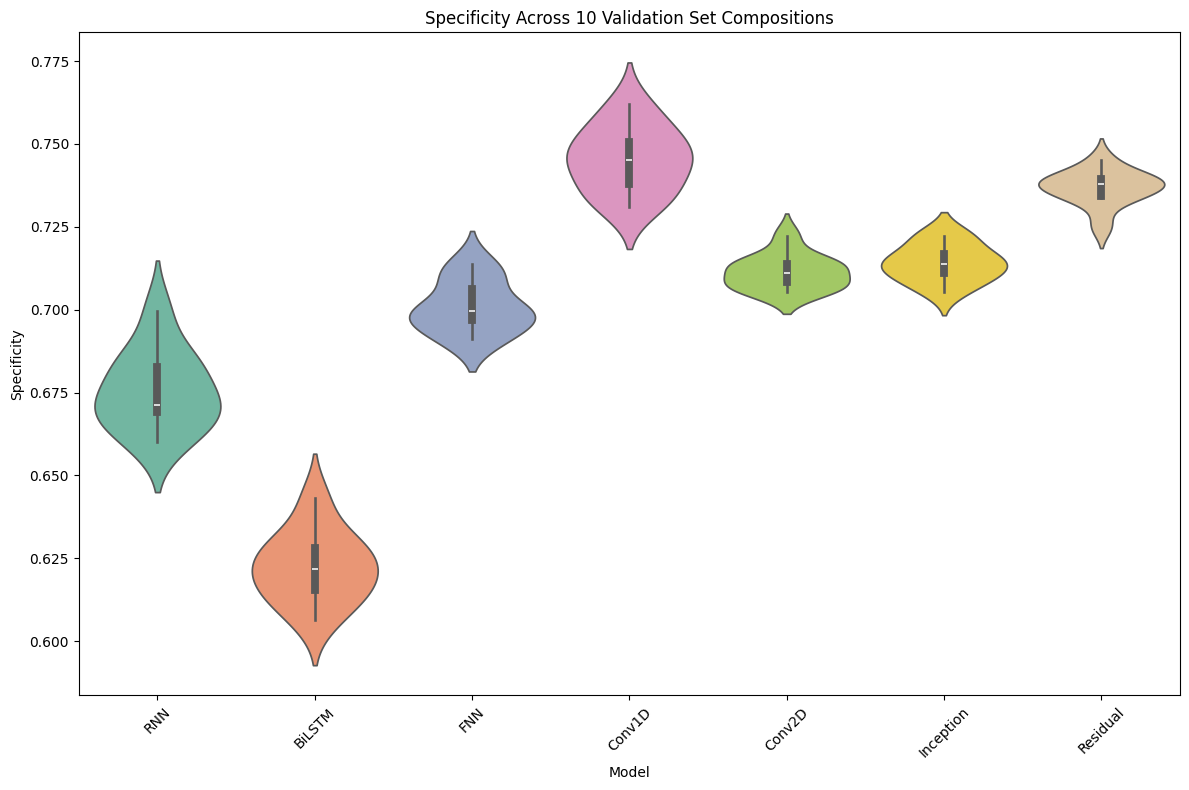

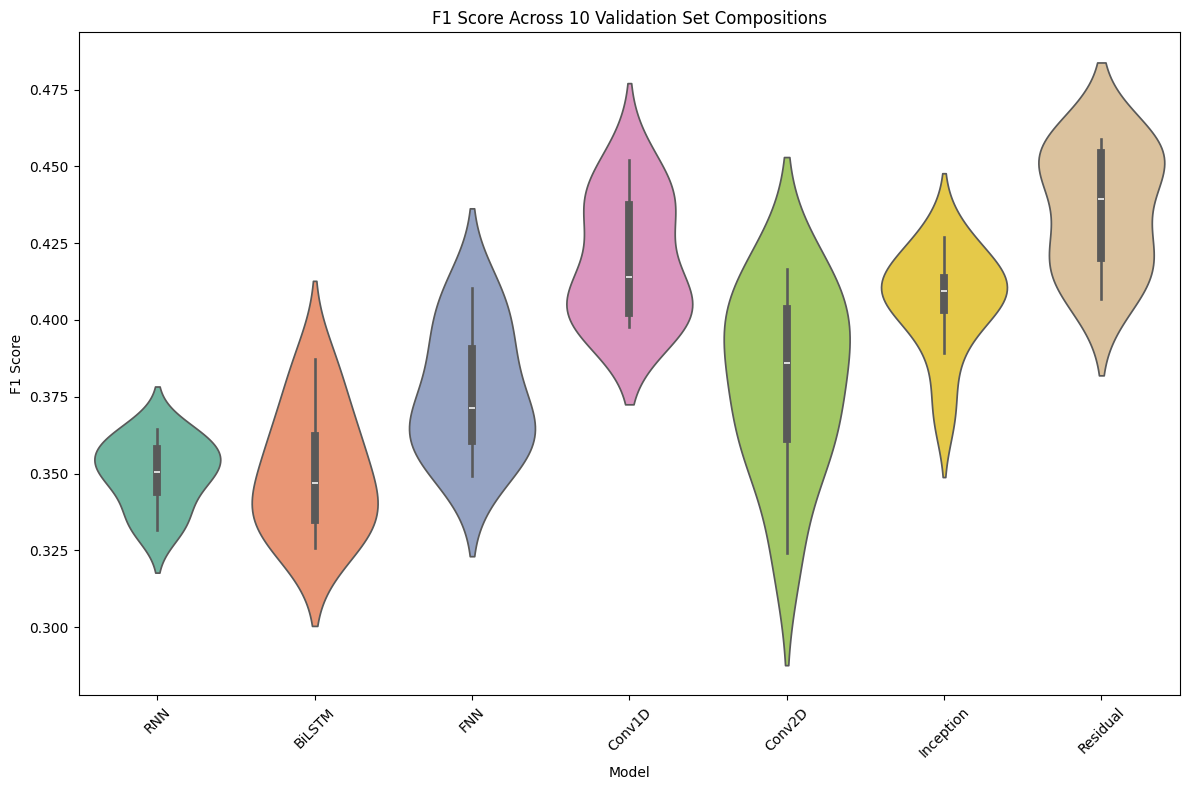

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create violin plots for each metric to visualize all results
for metric, df in results_df.items():
    plt.figure(figsize=(12, 8))
    sns.violinplot(data=df, palette="Set2")
    plt.title(f'{metric} Across 10 Validation Set Compositions')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'Plots/Model Selection/Word_embedding/Word_embedding_{metric}_violinplot.pdf', format='pdf')
    plt.show()


In [35]:
# Initialize an empty list to store formatted results
formatted_results = []

# Calculate mean and standard deviation for each metric and model
for metric, df in results_df.items():
    mean_std = df.aggregate(['mean', 'std']).T  # Compute mean and std for each model
    mean_std['Mean ± Std'] = mean_std.apply(
        lambda row: f"{row['mean']:.4f} ± {row['std']:.4f}", axis=1
    )
    mean_std = mean_std[['Mean ± Std']]  # Keep only the formatted column
    mean_std.reset_index(inplace=True)
    mean_std.rename(columns={'index': 'Model'}, inplace=True)
    mean_std['Metric'] = metric  # Add metric column for clarity
    formatted_results.append(mean_std)

# Concatenate all metrics into a single DataFrame
results_summary = pd.concat(formatted_results, ignore_index=True)

# Pivot the table to organize it with Metrics as columns
summary_table = results_summary.pivot(index='Model', columns='Metric', values='Mean ± Std')

# Print the tabular format
print("\nMean ± Std Results in Tabular Format:")
print(summary_table.to_string())

# Optionally save the results to a CSV or Markdown file for external use
summary_table.to_csv('Plots/Model Selection/Word_embedding/Word_embedding_model_results.csv')



Mean ± Std Results in Tabular Format:
Metric                 AUC            AUPRC         Accuracy         F1 Score              MCC        Precision           Recall      Specificity
Model                                                                                                                                            
BiLSTM     0.7071 ± 0.0271  0.2958 ± 0.0330  0.6430 ± 0.0109  0.3508 ± 0.0201  0.2739 ± 0.0354  0.2254 ± 0.0124  0.7918 ± 0.0543  0.6224 ± 0.0107
Conv1D     0.7492 ± 0.0239  0.3635 ± 0.0300  0.7463 ± 0.0077  0.4195 ± 0.0199  0.3508 ± 0.0309  0.2908 ± 0.0122  0.7531 ± 0.0522  0.7453 ± 0.0099
Conv2D     0.7179 ± 0.0340  0.3582 ± 0.0584  0.7129 ± 0.0082  0.3804 ± 0.0288  0.3004 ± 0.0450  0.2580 ± 0.0178  0.7245 ± 0.0695  0.7113 ± 0.0052
FNN        0.7168 ± 0.0254  0.3549 ± 0.0518  0.7047 ± 0.0076  0.3766 ± 0.0207  0.2969 ± 0.0333  0.2535 ± 0.0127  0.7327 ± 0.0531  0.7008 ± 0.0078
Inception  0.7469 ± 0.0203  0.3977 ± 0.0552  0.7221 ± 0.0053  0.4060 ± 0.0164  0.3395

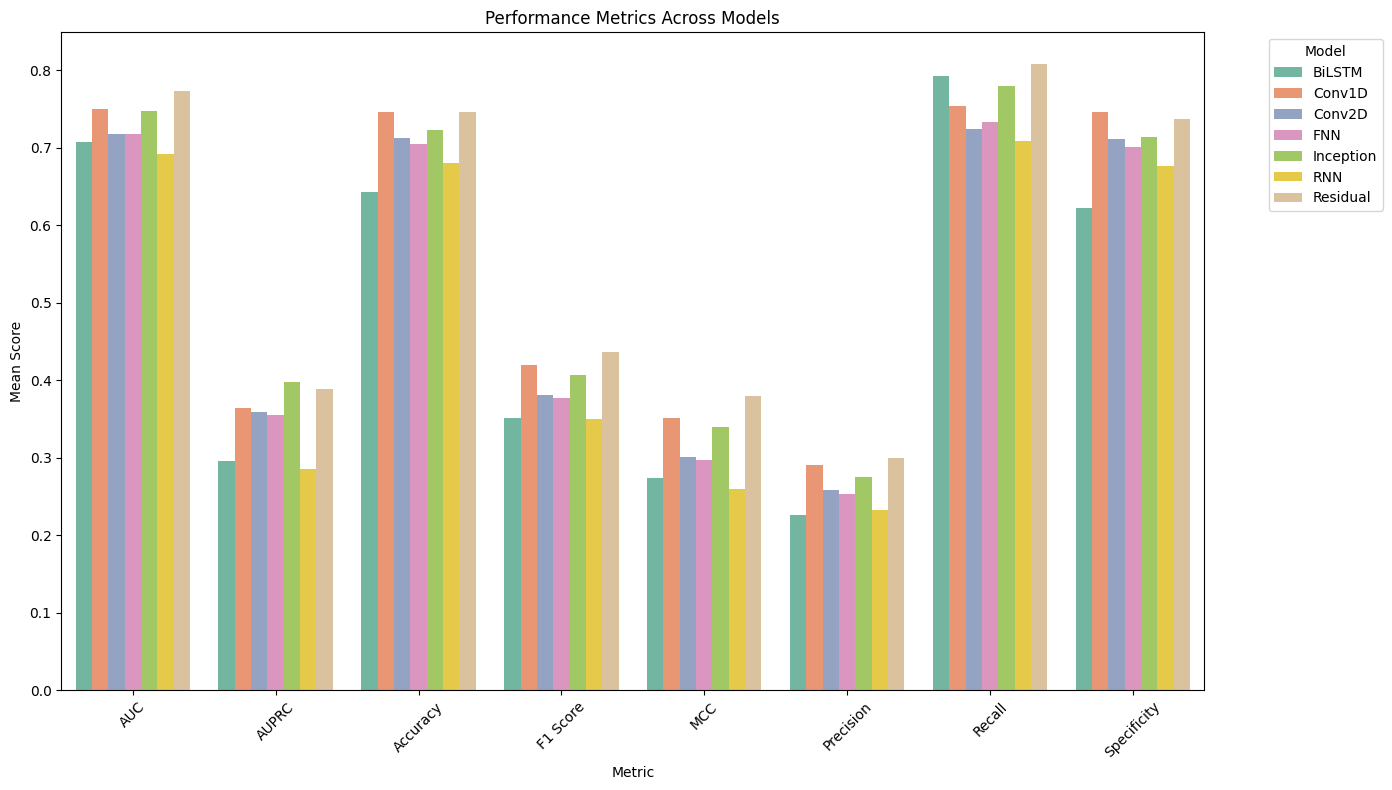

In [29]:
# Melt the summary table to long format for grouped bar plotting
melted_data = summary_table.reset_index().melt(id_vars=["Model"], var_name="Metric", value_name="Score")

# Extract mean scores (ignoring standard deviations) for plotting
melted_data["Mean"] = melted_data["Score"].apply(lambda x: float(x.split(" ± ")[0]))

# Plot grouped bar chart with metrics on the X-axis and models as colors
plt.figure(figsize=(14, 8))
sns.barplot(data=melted_data, x="Metric", y="Mean", hue="Model", palette="Set2")
plt.title("Performance Metrics Across Models")
plt.ylabel("Mean Score")
plt.xlabel("Metric")
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("Plots/Model Selection/Word_embedding/grouped_bar_results.pdf", format="pdf")
plt.show()
